# `np_arcsinh_f4`

In [1]:
from pynq import Overlay, allocate
import numpy as np

overlay = Overlay("/home/xilinx/jupyter_notebooks/np/overlays/np_arcsinh_f4.bit")

L = 2**13

A = allocate(shape=(L,), dtype="f4")
B = allocate(shape=(L,), dtype="f4")

A[:] = np.random.rand(L)
B[:] = np.zeros(L)

## NumPy

In [2]:
def np_arcsinh_f4_numpy(x1, out):
    np.arcsinh(x1, out)

B[:] = 0
np_arcsinh_f4_numpy(A, B)
print(B)

[0.52169037 0.6082437  0.3765918  ... 0.08418191 0.3103082  0.14881536]


## PYNQ

In [3]:
def np_arcsinh_f4_pynq(x1, out):
    overlay.np_arcsinh_f4_hw_0.mmio.write(0x10, x1.size)
    overlay.np_arcsinh_f4_hw_0.mmio.write(0x0, 0x01)

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.recvchannel.transfer(out)
    overlay.axi_dma_1.recvchannel.wait()

B[:] = 0
np_arcsinh_f4_pynq(A, B)
print(B)

[0.5216903  0.60824364 0.37659174 ... 0.08418187 0.31030816 0.14881533]


## pybind11

In [4]:
%%pybind11 np_arcsinh_f4

#include <unistd.h>
#include <fcntl.h>
#include <termios.h>
#include <sys/mman.h>

#define MM2S_DMACR 0x00
#define MM2S_DMACR_RS 0x00000001
#define MM2S_DMACR_Reset 0x00000004
#define MM2S_DMASR 0x04
#define MM2S_DMASR_Halted 0x00000001
#define MM2S_DMASR_Idle 0x00000002
#define MM2S_SA 0x18
#define MM2S_SA_MSB 0x1c
#define MM2S_LENGTH 0x28

#define S2MM_DMACR 0x30
#define S2MM_DMACR_RS 0x00000001
#define S2MM_DMACR_Reset 0x00000004
#define S2MM_DMASR 0x34
#define S2MM_DMASR_Halted 0x00000001
#define S2MM_DMASR_Idle 0x00000002
#define S2MM_DA 0x48
#define S2MM_DA_MSB 0x4c
#define S2MM_LENGTH 0x58

#define printf py::print

#define DMA_0_ADDR 0x40400000
#define dma_0_get(x) DMA_0_VADDR[x >> 2]
#define dma_0_set(x, y) DMA_0_VADDR[x >> 2] = y

#define DMA_1_ADDR 0x40410000
#define dma_1_get(x) DMA_1_VADDR[x >> 2]
#define dma_1_set(x, y) DMA_1_VADDR[x >> 2] = y

#define NP_ARCSINH_F4_ADDR 0x43C00000 
#define np_arcsinh_f4_set_stream_len(x) NP_ARCSINH_F4_VADDR[0x10 >> 2] = x
#define np_arcsinh_f4_start() NP_ARCSINH_F4_VADDR[0x00 >> 2] = 0x00000001

void np_arcsinh_f4(unsigned int x1_addr,
                   unsigned int out_addr,
                   unsigned int stream_len)
{
    int fd = open("/dev/mem", O_RDWR | O_SYNC);
    auto DMA_0_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
    );
    auto DMA_1_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
    );
    auto NP_ARCSINH_F4_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, NP_ARCSINH_F4_ADDR
    );
    
    np_arcsinh_f4_set_stream_len(stream_len);
    np_arcsinh_f4_start();
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_1_set(MM2S_DMACR, MM2S_DMACR_Reset);
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_1_set(MM2S_DMACR, MM2S_DMACR_RS);
    
    dma_0_set(MM2S_SA, x1_addr);
    dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));
        
    dma_1_set(S2MM_DA, out_addr);
    dma_1_set(S2MM_LENGTH, stream_len * sizeof(float));
    
    while(!(dma_1_get(S2MM_DMASR) & S2MM_DMASR_Idle));
    
    close(fd);
}

In [5]:
import np_arcsinh_f4 as calc

def np_arcsinh_f4_pybind11(x1, out):
    calc.np_arcsinh_f4(x1.physical_address, out.physical_address, x1.size)

B[:] = 0
np_arcsinh_f4_pybind11(A, B)
print(B)

[0.5216903  0.60824364 0.37659174 ... 0.08418187 0.31030816 0.14881533]


## CFFI

In [6]:
%%writefile build_np_arcsinh_f4_cffi.py

from cffi import FFI
ffibuilder = FFI()

ffibuilder.cdef(
    "void np_arcsinh_f4(unsigned int x1_addr, unsigned int out_addr, unsigned int stream_len);"
)

ffibuilder.set_source("np_arcsinh_f4_cffi",
r"""
    #include <unistd.h>
    #include <fcntl.h>
    #include <termios.h>
    #include <sys/mman.h>

    #define MM2S_DMACR 0x00
    #define MM2S_DMACR_RS 0x00000001
    #define MM2S_DMACR_Reset 0x00000004
    #define MM2S_DMASR 0x04
    #define MM2S_DMASR_Halted 0x00000001
    #define MM2S_DMASR_Idle 0x00000002
    #define MM2S_SA 0x18
    #define MM2S_SA_MSB 0x1c
    #define MM2S_LENGTH 0x28

    #define S2MM_DMACR 0x30
    #define S2MM_DMACR_RS 0x00000001
    #define S2MM_DMACR_Reset 0x00000004
    #define S2MM_DMASR 0x34
    #define S2MM_DMASR_Halted 0x00000001
    #define S2MM_DMASR_Idle 0x00000002
    #define S2MM_DA 0x48
    #define S2MM_DA_MSB 0x4c
    #define S2MM_LENGTH 0x58

    #define printf py::print

    #define DMA_0_ADDR 0x40400000
    #define dma_0_get(x) DMA_0_VADDR[x >> 2]
    #define dma_0_set(x, y) DMA_0_VADDR[x >> 2] = y

    #define DMA_1_ADDR 0x40410000
    #define dma_1_get(x) DMA_1_VADDR[x >> 2]
    #define dma_1_set(x, y) DMA_1_VADDR[x >> 2] = y

    #define NP_ARCSINH_F4_ADDR 0x43C00000 
    #define np_arcsinh_f4_set_stream_len(x) NP_ARCSINH_F4_VADDR[0x10 >> 2] = x
    #define np_arcsinh_f4_start() NP_ARCSINH_F4_VADDR[0x00 >> 2] = 0x00000001

    void np_arcsinh_f4(unsigned int x1_addr,
                       unsigned int out_addr,
                       unsigned int stream_len)
    {
        int fd = open("/dev/mem", O_RDWR | O_SYNC);
        volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
        );
        volatile unsigned int * DMA_1_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
        );
        volatile unsigned int * NP_ARCSINH_F4_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, NP_ARCSINH_F4_ADDR
        );

        np_arcsinh_f4_set_stream_len(stream_len);
        np_arcsinh_f4_start();

        dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_1_set(MM2S_DMACR, MM2S_DMACR_Reset);

        dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_1_set(MM2S_DMACR, MM2S_DMACR_RS);

        dma_0_set(MM2S_SA, x1_addr);
        dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_1_set(S2MM_DA, out_addr);
        dma_1_set(S2MM_LENGTH, stream_len * sizeof(float));

        while(!(dma_1_get(S2MM_DMASR) & S2MM_DMASR_Idle));

        close(fd);
    }
"""
)

if __name__ == "__main__":
    import sys
    print(sys.executable)
    ffibuilder.compile(verbose=True)

Overwriting build_np_arcsinh_f4_cffi.py


In [7]:
%%bash

/home/xilinx/perf_env/bin/python build_np_arcsinh_f4_cffi.py

/home/xilinx/perf_env/bin/python
generating ./np_arcsinh_f4_cffi.c
(already up-to-date)
the current directory is '/home/xilinx/jupyter_notebooks/np/build'
running build_ext
building 'np_arcsinh_f4_cffi' extension
arm-linux-gnueabihf-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/home/xilinx/perf_env/include -I/usr/include/python3.7m -c np_arcsinh_f4_cffi.c -o ./np_arcsinh_f4_cffi.o
arm-linux-gnueabihf-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 ./np_arcsinh_f4_cffi.o -o ./np_arcsinh_f4_cffi.cpython-37m-arm-linux-gnueabihf.so


In [8]:
from np_arcsinh_f4_cffi import lib as calc

def np_arcsinh_f4_cffi(x1, out):
    calc.np_arcsinh_f4(x1.physical_address, out.physical_address, x1.size)

B[:] = 0
np_arcsinh_f4_cffi(A, B)
print(B)

[0.5216903  0.60824364 0.37659174 ... 0.08418187 0.31030816 0.14881533]


## Timing analysis

kernel = 0, n = 4, t = 5.05037e-05
kernel = 1, n = 4, t = 0.1158263551
kernel = 2, n = 4, t = 0.0003761683
kernel = 3, n = 4, t = 0.0001072756
kernel = 0, n = 8, t = 4.78338e-05
kernel = 1, n = 8, t = 0.11520430190000001
kernel = 2, n = 8, t = 0.00037496820000000006
kernel = 3, n = 8, t = 0.0001196575
kernel = 0, n = 16, t = 5.2841300000000005e-05
kernel = 1, n = 16, t = 0.11499004540000002
kernel = 2, n = 16, t = 0.0001263987
kernel = 3, n = 16, t = 0.0001780784
kernel = 0, n = 32, t = 6.14747e-05
kernel = 1, n = 32, t = 0.11510474470000001
kernel = 2, n = 32, t = 0.0001201784
kernel = 3, n = 32, t = 0.0001859874
kernel = 0, n = 64, t = 7.70809e-05
kernel = 1, n = 64, t = 0.11487082840000001
kernel = 2, n = 64, t = 0.0001417474
kernel = 3, n = 64, t = 0.0001796784
kernel = 0, n = 128, t = 0.0001112889
kernel = 1, n = 128, t = 0.11502316850000001
kernel = 2, n = 128, t = 0.00011876620000000001
kernel = 3, n = 128, t = 0.0001869929
kernel = 0, n = 256, t = 0.00017832710000000002
kernel 

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy             ┃ pynq               ┃ pybind11          ┃ cffi               ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 4       │ 5.05037e-05       │ 0.1158263551       │ 0.0003761683      │ 0.0001072756       │
│ 8       │ 4.78338e-05       │ 0.115204301900000… │ 0.00037496820000… │ 0.0001196575       │
│ 16      │ 5.28413000000000… │ 0.114990045400000… │ 0.0001263987      │ 0.0001780784       │
│ 32      │ 6.14747e-05       │ 0.115104744700000… │ 0.0001201784      │ 0.0001859874       │
│ 64      │ 7.70809e-05       │ 0.114870828400000… │ 0.0001417474      │ 0.0001796784       │
│ 128     │ 0.0001112889      │ 0.115023168500000… │ 0.00011876620000… │ 0.0001869929       │
│ 256     │ 0.00017832710000… │ 0.122352663900000… │ 0.00080015830000… │ 0.000295442200000… │
│ 512     │ 0.0003199292      │ 0.1214138783       │ 0.00038652        │ 0.0001265526       │
│ 1024    │ 0.000601273       │ 0.1150717386       │ 0.00041410990000… │ 0.000133726200000… │
│ 2048    │ 0.0011453772      │ 0.115234617000000… │ 0.0003913101      │ 0.0001376972       │
│ 4096    │ 0.00244616560000… │ 0.115307487200000… │ 0.0004172246      │ 0.000159783100000… │
│ 8192    │ 0.0048389742      │ 0.1154510485       │ 0.00022827120000… │ 0.000263841        │
│ 16384   │ 0.00971564650000… │ 0.1157072971       │ 0.0005258866      │ 0.0003389521       │
│ 32768   │ 0.0192244895      │ 0.116346185900000… │ 0.0004875793      │ 0.0005604781       │
│ 65536   │ 0.03858818200000… │ 0.1158705985       │ 0.00078964850000… │ 0.0008556304       │
│ 131072  │ 0.07654216570000… │ 0.1158537198       │ 0.00157612520000… │ 0.0014519679       │
│ 262144  │ 0.1540680606      │ 0.1159974518       │ 0.00276945290000… │ 0.002746021200000… │
│ 524288  │ 0.3059591555      │ 0.1164757804       │ 0.00539094490000… │ 0.0053718338       │
│ 1048576 │ 0.616516181       │ 0.116486147200000… │ 0.0106310095      │ 0.010747537800000… │
│ 2097152 │ 1.23064638        │ 0.116945278600000… │ 0.0211223557      │ 0.0211154344       │
└─────────┴───────────────────┴────────────────────┴───────────────────┴────────────────────┘

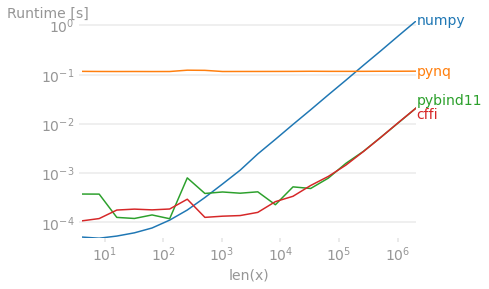

In [9]:
import time
from perfplot._main import PerfplotData

def _setup(n):
    A = allocate(shape=(n,), dtype="f4")
    B = allocate(shape=(n,), dtype="f4")

    A[:] = np.random.rand(n)
    B[:] = np.zeros(n)
    
    return A, B

kernels = [
    np_arcsinh_f4_numpy,
    np_arcsinh_f4_pynq,
    np_arcsinh_f4_pybind11,
    np_arcsinh_f4_cffi,
]

iters = 10
n_range = [2 ** k for k in range(2, 22)] 
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)

labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "len(x)"

for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):        
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        
        print(f"kernel = {j}, n = {n}, t = {timings_s[j,i]}")
        
    for x in data:
        x.freebuffer()
        
p = PerfplotData(
    n_range,
    timings_s,
    None,
    labels,
    xlabel
)

print(p)

p.show()

# `np_arctan2_arcsinh_f4`

In [10]:
from pynq import Overlay, allocate
import numpy as np

overlay = Overlay("/home/xilinx/jupyter_notebooks/np/overlays/np_arctan2_arcsinh_f4.bit")

L = 2**13

A = allocate(shape=(L,), dtype="f4")
B = allocate(shape=(L,), dtype="f4")

A[:] = np.random.rand(L)
B[:] = np.zeros(L)

## PYNQ

In [11]:
def np_arcsinh_f4_pynq_multi(x1, out):
    overlay.axis_switch_0.mmio.write(0x44, 0x00)  # M01 -- S00
    overlay.axis_switch_0.mmio.write(0x4c, 0x03)  # M03 -- S03
    overlay.axis_switch_0.mmio.write(0x00, 0x02)  # COMMIT
    
    overlay.np_arcsinh_f4_hw_0.mmio.write(0x10, x1.size)
    overlay.np_arcsinh_f4_hw_0.mmio.write(0x00, 0x01)

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_2.recvchannel.transfer(out)
    overlay.axi_dma_2.recvchannel.wait()

B[:] = 0
np_arcsinh_f4_pynq_multi(A, B)
print(B)

[0.41533476 0.2572679  0.48621798 ... 0.7539894  0.835135   0.84219265]


## pybind11

In [12]:
%%pybind11 np_arctan2_arcsinh_f4

#include <unistd.h>
#include <fcntl.h>
#include <termios.h>
#include <sys/mman.h>

#define MM2S_DMACR 0x00
#define MM2S_DMACR_RS 0x00000001
#define MM2S_DMACR_Reset 0x00000004
#define MM2S_DMASR 0x04
#define MM2S_DMASR_Halted 0x00000001
#define MM2S_DMASR_Idle 0x00000002
#define MM2S_SA 0x18
#define MM2S_SA_MSB 0x1c
#define MM2S_LENGTH 0x28

#define S2MM_DMACR 0x30
#define S2MM_DMACR_RS 0x00000001
#define S2MM_DMACR_Reset 0x00000004
#define S2MM_DMASR 0x34
#define S2MM_DMASR_Halted 0x00000001
#define S2MM_DMASR_Idle 0x00000002
#define S2MM_DA 0x48
#define S2MM_DA_MSB 0x4c
#define S2MM_LENGTH 0x58

#define printf py::print

#define DMA_0_ADDR 0x40400000
#define dma_0_get(x) DMA_0_VADDR[x >> 2]
#define dma_0_set(x, y) DMA_0_VADDR[x >> 2] = y

#define DMA_1_ADDR 0x40410000
#define dma_1_get(x) DMA_1_VADDR[x >> 2]
#define dma_1_set(x, y) DMA_1_VADDR[x >> 2] = y

#define DMA_2_ADDR 0x40420000
#define dma_2_get(x) DMA_2_VADDR[x >> 2]
#define dma_2_set(x, y) DMA_2_VADDR[x >> 2] = y

#define NP_ARCTAN2_F4_ADDR 0x43C00000
#define np_arctan2_f4_set_stream_len(x) NP_ARCTAN2_F4_VADDR[0x10 >> 2] = x
#define np_arctan2_f4_start() NP_ARCTAN2_F4_VADDR[0x00 >> 2] = 0x00000001

#define NP_ARCSINH_F4_ADDR 0x43C10000
#define np_arcsinh_f4_set_stream_len(x) NP_ARCSINH_F4_VADDR[0x10 >> 2] = x
#define np_arcsinh_f4_start() NP_ARCSINH_F4_VADDR[0x00 >> 2] = 0x00000001

#define AXIS_SWITCH_ADDR 0x43C20000
#define axis_switch_set(x, y) AXIS_SWITCH_VADDR[x >> 2] = y
#define axis_switch_start() AXIS_SWITCH_VADDR[0x00 >> 2] = 0x00000002

void np_arctan2_f4(unsigned int x1_addr,
                   unsigned int x2_addr,
                   unsigned int out_addr,
                   unsigned int stream_len)
{
    int fd = open("/dev/mem", O_RDWR | O_SYNC);
    auto DMA_0_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
    );
    auto DMA_1_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
    );
    auto DMA_2_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
    );
    auto NP_ARCTAN2_F4_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, NP_ARCTAN2_F4_ADDR
    );
    auto AXIS_SWITCH_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, AXIS_SWITCH_ADDR
    );

    axis_switch_set(0x40, 0x00);
    axis_switch_set(0x48, 0x01);
    axis_switch_set(0x4c, 0x02);
    axis_switch_start();
        
    np_arctan2_f4_set_stream_len(stream_len);
    np_arctan2_f4_start();
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);
    
    dma_0_set(MM2S_SA, x1_addr);
    dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_1_set(MM2S_SA, x2_addr);
    dma_1_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_2_set(S2MM_DA, out_addr);
    dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));
    
    while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));
    
    close(fd);
}

void np_arcsinh_f4(unsigned int x1_addr,
                   unsigned int out_addr,
                   unsigned int stream_len)
{
    int fd = open("/dev/mem", O_RDWR | O_SYNC);
    auto DMA_0_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
    );
    auto DMA_2_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
    );
    auto NP_ARCSINH_F4_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, NP_ARCSINH_F4_ADDR
    );
    auto AXIS_SWITCH_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, AXIS_SWITCH_ADDR
    );

    axis_switch_set(0x44, 0x00);
    axis_switch_set(0x4c, 0x03);
    axis_switch_start();
        
    np_arcsinh_f4_set_stream_len(stream_len);
    np_arcsinh_f4_start();
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);
    
    dma_0_set(MM2S_SA, x1_addr);
    dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_2_set(S2MM_DA, out_addr);
    dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));
    
    while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));
    
    close(fd);
}

In [13]:
import np_arctan2_arcsinh_f4 as calc

def np_arcsinh_f4_pybind11_multi(x1, out):
    calc.np_arcsinh_f4(x1.physical_address, out.physical_address, x1.size)

B[:] = 0
np_arcsinh_f4_pybind11_multi(A, B)
print(B)

[0.41533476 0.2572679  0.48621798 ... 0.7539894  0.835135   0.84219265]


## CFFI

In [14]:
%%writefile build_np_arctan2_arcsinh_f4_cffi.py

from cffi import FFI
ffibuilder = FFI()

ffibuilder.cdef(
    "void np_arctan2_f4(unsigned int x1_addr, unsigned int x2_addr, unsigned int out_addr, unsigned int stream_len);"
    "void np_arcsinh_f4(unsigned int x1_addr, unsigned int out_addr, unsigned int stream_len);"
)

ffibuilder.set_source("np_arctan2_arcsinh_f4_cffi",
r"""
    #include <unistd.h>
    #include <fcntl.h>
    #include <termios.h>
    #include <sys/mman.h>

    #define MM2S_DMACR 0x00
    #define MM2S_DMACR_RS 0x00000001
    #define MM2S_DMACR_Reset 0x00000004
    #define MM2S_DMASR 0x04
    #define MM2S_DMASR_Halted 0x00000001
    #define MM2S_DMASR_Idle 0x00000002
    #define MM2S_SA 0x18
    #define MM2S_SA_MSB 0x1c
    #define MM2S_LENGTH 0x28

    #define S2MM_DMACR 0x30
    #define S2MM_DMACR_RS 0x00000001
    #define S2MM_DMACR_Reset 0x00000004
    #define S2MM_DMASR 0x34
    #define S2MM_DMASR_Halted 0x00000001
    #define S2MM_DMASR_Idle 0x00000002
    #define S2MM_DA 0x48
    #define S2MM_DA_MSB 0x4c
    #define S2MM_LENGTH 0x58

    #define printf py::print

    #define DMA_0_ADDR 0x40400000
    #define dma_0_get(x) DMA_0_VADDR[x >> 2]
    #define dma_0_set(x, y) DMA_0_VADDR[x >> 2] = y

    #define DMA_1_ADDR 0x40410000
    #define dma_1_get(x) DMA_1_VADDR[x >> 2]
    #define dma_1_set(x, y) DMA_1_VADDR[x >> 2] = y

    #define DMA_2_ADDR 0x40420000
    #define dma_2_get(x) DMA_2_VADDR[x >> 2]
    #define dma_2_set(x, y) DMA_2_VADDR[x >> 2] = y

    #define NP_ARCTAN2_F4_ADDR 0x43C00000
    #define np_arctan2_f4_set_stream_len(x) NP_ARCTAN2_F4_VADDR[0x10 >> 2] = x
    #define np_arctan2_f4_start() NP_ARCTAN2_F4_VADDR[0x00 >> 2] = 0x00000001

    #define NP_ARCSINH_F4_ADDR 0x43C10000
    #define np_arcsinh_f4_set_stream_len(x) NP_ARCSINH_F4_VADDR[0x10 >> 2] = x
    #define np_arcsinh_f4_start() NP_ARCSINH_F4_VADDR[0x00 >> 2] = 0x00000001

    #define AXIS_SWITCH_ADDR 0x43C20000
    #define axis_switch_set(x, y) AXIS_SWITCH_VADDR[x >> 2] = y
    #define axis_switch_start() AXIS_SWITCH_VADDR[0x00 >> 2] = 0x00000002

    void np_arctan2_f4(unsigned int x1_addr,
                       unsigned int x2_addr,
                       unsigned int out_addr,
                       unsigned int stream_len)
    {
        int fd = open("/dev/mem", O_RDWR | O_SYNC);
        volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
        );
        volatile unsigned int * DMA_1_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
        );
        volatile unsigned int * DMA_2_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
        );
        volatile unsigned int * NP_ARCTAN2_F4_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, NP_ARCTAN2_F4_ADDR
        );
        volatile unsigned int * AXIS_SWITCH_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, AXIS_SWITCH_ADDR
        );

        axis_switch_set(0x40, 0x00);
        axis_switch_set(0x48, 0x01);
        axis_switch_set(0x4c, 0x02);
        axis_switch_start();

        np_arctan2_f4_set_stream_len(stream_len);
        np_arctan2_f4_start();

        dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);

        dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);

        dma_0_set(MM2S_SA, x1_addr);
        dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_1_set(MM2S_SA, x2_addr);
        dma_1_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_2_set(S2MM_DA, out_addr);
        dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));

        while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));

        close(fd);
    }

    void np_arcsinh_f4(unsigned int x1_addr,
                       unsigned int out_addr,
                       unsigned int stream_len)
    {
        int fd = open("/dev/mem", O_RDWR | O_SYNC);
        volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
        );
        volatile unsigned int * DMA_2_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
        );
        volatile unsigned int * NP_ARCSINH_F4_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, NP_ARCSINH_F4_ADDR
        );
        volatile unsigned int * AXIS_SWITCH_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, AXIS_SWITCH_ADDR
        );

        axis_switch_set(0x44, 0x00);
        axis_switch_set(0x4c, 0x03);
        axis_switch_start();

        np_arcsinh_f4_set_stream_len(stream_len);
        np_arcsinh_f4_start();

        dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);

        dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);

        dma_0_set(MM2S_SA, x1_addr);
        dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_2_set(S2MM_DA, out_addr);
        dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));

        while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));

        close(fd);
    }
"""
)

if __name__ == "__main__":
    import sys
    print(sys.executable)
    ffibuilder.compile(verbose=True)

Overwriting build_np_arctan2_arcsinh_f4_cffi.py


In [15]:
%%bash

/home/xilinx/perf_env/bin/python build_np_arctan2_arcsinh_f4_cffi.py

/home/xilinx/perf_env/bin/python
generating ./np_arctan2_arcsinh_f4_cffi.c
(already up-to-date)
the current directory is '/home/xilinx/jupyter_notebooks/np/build'
running build_ext
building 'np_arctan2_arcsinh_f4_cffi' extension
arm-linux-gnueabihf-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/home/xilinx/perf_env/include -I/usr/include/python3.7m -c np_arctan2_arcsinh_f4_cffi.c -o ./np_arctan2_arcsinh_f4_cffi.o
arm-linux-gnueabihf-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 ./np_arctan2_arcsinh_f4_cffi.o -o ./np_arctan2_arcsinh_f4_cffi.cpython-37m-arm-linux-gnueabihf

In [16]:
from np_arctan2_arcsinh_f4_cffi import lib as calc

def np_arcsinh_f4_cffi_multi(x1, out):
    calc.np_arcsinh_f4(x1.physical_address, out.physical_address, x1.size)

B[:] = 0
np_arcsinh_f4_cffi_multi(A, B)
print(B)

[0.41533476 0.2572679  0.48621798 ... 0.7539894  0.835135   0.84219265]


## Timing analysis

kernel = 0, n = 4, t = 0.24446342850000002
kernel = 1, n = 4, t = 0.00013170270000000003
kernel = 2, n = 4, t = 0.0001387113
kernel = 0, n = 8, t = 0.24462102400000002
kernel = 1, n = 8, t = 0.0001373431
kernel = 2, n = 8, t = 0.00014244460000000002
kernel = 0, n = 16, t = 0.2446675162
kernel = 1, n = 16, t = 0.00039768490000000007
kernel = 2, n = 16, t = 0.0001559959
kernel = 0, n = 32, t = 0.24561361450000002
kernel = 1, n = 32, t = 0.00014541979999999999
kernel = 2, n = 32, t = 0.00014776870000000002
kernel = 0, n = 64, t = 0.24490922280000002
kernel = 1, n = 64, t = 0.00039643690000000005
kernel = 2, n = 64, t = 0.0001581693
kernel = 0, n = 128, t = 0.244734886
kernel = 1, n = 128, t = 0.0003985141
kernel = 2, n = 128, t = 0.00015788670000000003
kernel = 0, n = 256, t = 0.24457976680000001
kernel = 1, n = 256, t = 0.0003987837
kernel = 2, n = 256, t = 0.00016153600000000002
kernel = 0, n = 512, t = 0.25749270980000005
kernel = 1, n = 512, t = 0.00015478610000000003
kernel = 2, n = 

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ pynq_multi          ┃ pybind11_multi         ┃ cffi_multi             ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 4       │ 0.24446342850000002 │ 0.00013170270000000003 │ 0.0001387113           │
│ 8       │ 0.24462102400000002 │ 0.0001373431           │ 0.00014244460000000002 │
│ 16      │ 0.2446675162        │ 0.00039768490000000007 │ 0.0001559959           │
│ 32      │ 0.24561361450000002 │ 0.00014541979999999999 │ 0.00014776870000000002 │
│ 64      │ 0.24490922280000002 │ 0.00039643690000000005 │ 0.0001581693           │
│ 128     │ 0.244734886         │ 0.0003985141           │ 0.00015788670000000003 │
│ 256     │ 0.24457976680000001 │ 0.0003987837           │ 0.00016153600000000002 │
│ 512     │ 0.25749270980000005 │ 0.00015478610000000003 │ 0.000154675            │
│ 1024    │ 0.2443956166        │ 0.00015598090000000002 │ 0.000167717            │
│ 2048    │ 0.24446290950000002 │ 0.0004027913           │ 0.0001738298           │
│ 4096    │ 0.2443934352        │ 0.0001892768           │ 0.0001870282           │
│ 8192    │ 0.24641550330000003 │ 0.00023633560000000002 │ 0.00022252120000000003 │
│ 16384   │ 0.2454024326        │ 0.000325229            │ 0.0003541856           │
│ 32768   │ 0.2448543806        │ 0.0007011379000000001  │ 0.0005039389000000001  │
│ 65536   │ 0.2448172855        │ 0.0010186498000000002  │ 0.0008340194000000001  │
│ 131072  │ 0.2450297036        │ 0.0014786911000000001  │ 0.0014665619           │
│ 262144  │ 0.2584985386        │ 0.0027939230000000002  │ 0.0027696508           │
│ 524288  │ 0.24455177530000002 │ 0.005416715700000001   │ 0.0053966046           │
│ 1048576 │ 0.2453414935        │ 0.010655712300000002   │ 0.0107529036           │
│ 2097152 │ 0.24653333530000002 │ 0.021136124300000003   │ 0.0211380347           │
└─────────┴─────────────────────┴────────────────────────┴────────────────────────┘

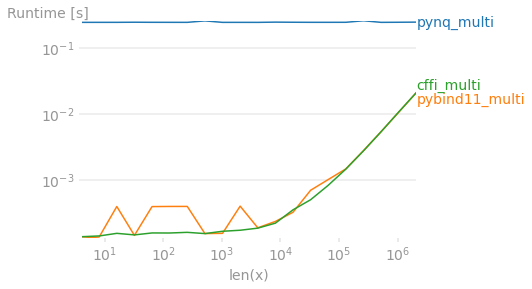

In [17]:
import time
from perfplot._main import PerfplotData

def _setup(n):
    A = allocate(shape=(n,), dtype="f4")
    B = allocate(shape=(n,), dtype="f4")
    C = allocate(shape=(n,), dtype="f4")

    A[:] = np.random.rand(n)
    B[:] = np.zeros(n)
    
    return A, B

kernels = [
    np_arcsinh_f4_pynq_multi,
    np_arcsinh_f4_pybind11_multi,
    np_arcsinh_f4_cffi_multi,
]

iters = 10
n_range = [2 ** k for k in range(2, 22)] 
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)

labels = ["pynq_multi", "pybind11_multi", "cffi_multi"]
xlabel = "len(x)"

for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):        
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        
        print(f"kernel = {j}, n = {n}, t = {timings_s[j,i]}")
        
    for x in data:
        x.freebuffer()
        
q = PerfplotData(
    n_range,
    timings_s,
    None,
    labels,
    xlabel
)

print(q)

q.show()

# `np_arctan2_arcsinh_f4_combi`

In [18]:
from pynq import Overlay, allocate
import numpy as np

overlay = Overlay("/home/xilinx/jupyter_notebooks/np/overlays/np_arctan2_arcsinh_f4_combi.bit")

L = 2**13

A = allocate(shape=(L,), dtype="f4")
B = allocate(shape=(L,), dtype="f4")

A[:] = np.random.rand(L)
B[:] = np.zeros(L)

## PYNQ

In [19]:
def np_arcsinh_f4_combi_pynq(x1, out):
    overlay.np_arctan2_arcsinh_f_0.mmio.write(0x10, x1.size)
    overlay.np_arctan2_arcsinh_f_0.mmio.write(0x18, 0x01)
    overlay.np_arctan2_arcsinh_f_0.mmio.write(0x00, 0x01)

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_2.recvchannel.transfer(out)
    overlay.axi_dma_2.recvchannel.wait()

B[:] = 0
np_arcsinh_f4_combi_pynq(A, B)
print(B)

[0.655137   0.6396124  0.75206167 ... 0.328253   0.54366285 0.13177188]


## pybind11

In [20]:
%%pybind11 np_arctan2_arcsinh_f4_combi

#include <unistd.h>
#include <fcntl.h>
#include <termios.h>
#include <sys/mman.h>

#define MM2S_DMACR 0x00
#define MM2S_DMACR_RS 0x00000001
#define MM2S_DMACR_Reset 0x00000004
#define MM2S_DMASR 0x04
#define MM2S_DMASR_Halted 0x00000001
#define MM2S_DMASR_Idle 0x00000002
#define MM2S_SA 0x18
#define MM2S_SA_MSB 0x1c
#define MM2S_LENGTH 0x28

#define S2MM_DMACR 0x30
#define S2MM_DMACR_RS 0x00000001
#define S2MM_DMACR_Reset 0x00000004
#define S2MM_DMASR 0x34
#define S2MM_DMASR_Halted 0x00000001
#define S2MM_DMASR_Idle 0x00000002
#define S2MM_DA 0x48
#define S2MM_DA_MSB 0x4c
#define S2MM_LENGTH 0x58

#define printf py::print

#define DMA_0_ADDR 0x40400000
#define dma_0_get(x) DMA_0_VADDR[x >> 2]
#define dma_0_set(x, y) DMA_0_VADDR[x >> 2] = y

#define DMA_1_ADDR 0x40410000
#define dma_1_get(x) DMA_1_VADDR[x >> 2]
#define dma_1_set(x, y) DMA_1_VADDR[x >> 2] = y

#define DMA_2_ADDR 0x40420000
#define dma_2_get(x) DMA_2_VADDR[x >> 2]
#define dma_2_set(x, y) DMA_2_VADDR[x >> 2] = y

#define NP_ARCTAN2_ARCSINH_F4_ADDR 0x43C00000
#define np_arctan2_arcsinh_f4_set_stream_len(x)  NP_ARCTAN2_ARCSINH_F4_VADDR[0x10 >> 2] = x
#define np_arctan2_arcsinh_f4_set_sel(x)  NP_ARCTAN2_ARCSINH_F4_VADDR[0x18 >> 2] = x
#define np_arctan2_arcsinh_f4_start()  NP_ARCTAN2_ARCSINH_F4_VADDR[0x00 >> 2] = 0x00000001

void np_arctan2_f4(unsigned int x1_addr,
                   unsigned int x2_addr,
                   unsigned int out_addr,
                   unsigned int stream_len)
{
    int fd = open("/dev/mem", O_RDWR | O_SYNC);
    auto DMA_0_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
    );
    auto DMA_1_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
    );
    auto DMA_2_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
    );
    auto NP_ARCTAN2_ARCSINH_F4_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, NP_ARCTAN2_ARCSINH_F4_ADDR
    );

    np_arctan2_arcsinh_f4_set_stream_len(stream_len);
    np_arctan2_arcsinh_f4_set_sel(0x00);
    np_arctan2_arcsinh_f4_start();
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);
    
    dma_0_set(MM2S_SA, x1_addr);
    dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_1_set(MM2S_SA, x2_addr);
    dma_1_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_2_set(S2MM_DA, out_addr);
    dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));
    
    while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));
    
    close(fd);
}

void np_arcsinh_f4(unsigned int x1_addr,
                   unsigned int out_addr,
                   unsigned int stream_len)
{
    int fd = open("/dev/mem", O_RDWR | O_SYNC);
    auto DMA_0_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
    );
    auto DMA_2_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
    );
    auto NP_ARCTAN2_ARCSINH_F4_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, NP_ARCTAN2_ARCSINH_F4_ADDR
    );

    np_arctan2_arcsinh_f4_set_stream_len(stream_len);
    np_arctan2_arcsinh_f4_set_sel(0x01);
    np_arctan2_arcsinh_f4_start();       
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);
    
    dma_0_set(MM2S_SA, x1_addr);
    dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_2_set(S2MM_DA, out_addr);
    dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));
    
    while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));
    
    close(fd);
}

In [21]:
import np_arctan2_arcsinh_f4_combi as calc

def np_arcsinh_f4_combi_pybind11(x1, out):
    calc.np_arcsinh_f4(x1.physical_address, out.physical_address, x1.size)

B[:] = 0
np_arcsinh_f4_combi_pybind11(A, B)
print(B)

[0.655137   0.6396124  0.75206167 ... 0.328253   0.54366285 0.13177188]


## CFFI

In [22]:
%%writefile build_np_arctan2_arcsinh_f4_combi_cffi.py

from cffi import FFI
ffibuilder = FFI()

ffibuilder.cdef(
    "void np_arctan2_f4(unsigned int x1_addr, unsigned int x2_addr, unsigned int out_addr, unsigned int stream_len);"
    "void np_arcsinh_f4(unsigned int x1_addr, unsigned int out_addr, unsigned int stream_len);"
)

ffibuilder.set_source("np_arctan2_arcsinh_f4_combi_cffi",
r"""
    #include <unistd.h>
    #include <fcntl.h>
    #include <termios.h>
    #include <sys/mman.h>

    #define MM2S_DMACR 0x00
    #define MM2S_DMACR_RS 0x00000001
    #define MM2S_DMACR_Reset 0x00000004
    #define MM2S_DMASR 0x04
    #define MM2S_DMASR_Halted 0x00000001
    #define MM2S_DMASR_Idle 0x00000002
    #define MM2S_SA 0x18
    #define MM2S_SA_MSB 0x1c
    #define MM2S_LENGTH 0x28

    #define S2MM_DMACR 0x30
    #define S2MM_DMACR_RS 0x00000001
    #define S2MM_DMACR_Reset 0x00000004
    #define S2MM_DMASR 0x34
    #define S2MM_DMASR_Halted 0x00000001
    #define S2MM_DMASR_Idle 0x00000002
    #define S2MM_DA 0x48
    #define S2MM_DA_MSB 0x4c
    #define S2MM_LENGTH 0x58

    #define printf py::print

    #define DMA_0_ADDR 0x40400000
    #define dma_0_get(x) DMA_0_VADDR[x >> 2]
    #define dma_0_set(x, y) DMA_0_VADDR[x >> 2] = y

    #define DMA_1_ADDR 0x40410000
    #define dma_1_get(x) DMA_1_VADDR[x >> 2]
    #define dma_1_set(x, y) DMA_1_VADDR[x >> 2] = y

    #define DMA_2_ADDR 0x40420000
    #define dma_2_get(x) DMA_2_VADDR[x >> 2]
    #define dma_2_set(x, y) DMA_2_VADDR[x >> 2] = y

    #define NP_ARCTAN2_ARCSINH_F4_ADDR 0x43C00000
    #define np_arctan2_arcsinh_f4_set_stream_len(x)  NP_ARCTAN2_ARCSINH_F4_VADDR[0x10 >> 2] = x
    #define np_arctan2_arcsinh_f4_set_sel(x)  NP_ARCTAN2_ARCSINH_F4_VADDR[0x18 >> 2] = x
    #define np_arctan2_arcsinh_f4_start()  NP_ARCTAN2_ARCSINH_F4_VADDR[0x00 >> 2] = 0x00000001

    void np_arctan2_f4(unsigned int x1_addr,
                       unsigned int x2_addr,
                       unsigned int out_addr,
                       unsigned int stream_len)
    {
        int fd = open("/dev/mem", O_RDWR | O_SYNC);
        volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
        );
        volatile unsigned int * DMA_1_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
        );
        volatile unsigned int * DMA_2_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
        );
        volatile unsigned int * NP_ARCTAN2_ARCSINH_F4_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, NP_ARCTAN2_ARCSINH_F4_ADDR
        );

        np_arctan2_arcsinh_f4_set_stream_len(stream_len);
        np_arctan2_arcsinh_f4_set_sel(0x00);
        np_arctan2_arcsinh_f4_start();

        dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);

        dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);

        dma_0_set(MM2S_SA, x1_addr);
        dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_1_set(MM2S_SA, x2_addr);
        dma_1_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_2_set(S2MM_DA, out_addr);
        dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));

        while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));

        close(fd);
    }

    void np_arcsinh_f4(unsigned int x1_addr,
                       unsigned int out_addr,
                       unsigned int stream_len)
    {
        int fd = open("/dev/mem", O_RDWR | O_SYNC);
        volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
        );
        volatile unsigned int * DMA_2_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
        );
        volatile unsigned int * NP_ARCTAN2_ARCSINH_F4_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, NP_ARCTAN2_ARCSINH_F4_ADDR
        );

        np_arctan2_arcsinh_f4_set_stream_len(stream_len);
        np_arctan2_arcsinh_f4_set_sel(0x01);
        np_arctan2_arcsinh_f4_start();       

        dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);

        dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);

        dma_0_set(MM2S_SA, x1_addr);
        dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_2_set(S2MM_DA, out_addr);
        dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));

        while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));

        close(fd);
    }
"""
)

if __name__ == "__main__":
    import sys
    print(sys.executable)
    ffibuilder.compile(verbose=True)

Overwriting build_np_arctan2_arcsinh_f4_combi_cffi.py


In [23]:
%%bash

/home/xilinx/perf_env/bin/python build_np_arctan2_arcsinh_f4_combi_cffi.py

/home/xilinx/perf_env/bin/python
generating ./np_arctan2_arcsinh_f4_combi_cffi.c
the current directory is '/home/xilinx/jupyter_notebooks/np/build'
running build_ext
building 'np_arctan2_arcsinh_f4_combi_cffi' extension
arm-linux-gnueabihf-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/home/xilinx/perf_env/include -I/usr/include/python3.7m -c np_arctan2_arcsinh_f4_combi_cffi.c -o ./np_arctan2_arcsinh_f4_combi_cffi.o
arm-linux-gnueabihf-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 ./np_arctan2_arcsinh_f4_combi_cffi.o -o ./np_arctan2_arcsinh_f4_combi_cffi.cpython-37m-arm-

In [24]:
from np_arctan2_arcsinh_f4_combi_cffi import lib as calc

def np_arcsinh_f4_combi_cffi(x1, out):
    calc.np_arcsinh_f4(x1.physical_address, out.physical_address, x1.size)

B[:] = 0
np_arcsinh_f4_combi_cffi(A, B)
print(B)

[0.655137   0.6396124  0.75206167 ... 0.328253   0.54366285 0.13177188]


## Timing analysis

kernel = 0, n = 4, t = 0.1601298099
kernel = 1, n = 4, t = 0.0001215975
kernel = 2, n = 4, t = 0.00011486210000000002
kernel = 0, n = 8, t = 0.15980521830000002
kernel = 1, n = 8, t = 0.0003823225
kernel = 2, n = 8, t = 0.00013142870000000002
kernel = 0, n = 16, t = 0.15943975640000002
kernel = 1, n = 16, t = 0.00012780620000000002
kernel = 2, n = 16, t = 0.00011778010000000001
kernel = 0, n = 32, t = 0.16137710130000002
kernel = 1, n = 32, t = 0.0003752418
kernel = 2, n = 32, t = 0.0001287836
kernel = 0, n = 64, t = 0.1626743296
kernel = 1, n = 64, t = 0.0009471551
kernel = 2, n = 64, t = 0.0006001997
kernel = 0, n = 128, t = 0.17006371730000003
kernel = 1, n = 128, t = 0.0003839631
kernel = 2, n = 128, t = 0.00014712620000000001
kernel = 0, n = 256, t = 0.159780629
kernel = 1, n = 256, t = 0.0001271086
kernel = 2, n = 256, t = 0.00013956610000000002
kernel = 0, n = 512, t = 0.15975112530000002
kernel = 1, n = 512, t = 0.0001500304
kernel = 2, n = 512, t = 0.0001293268
kernel = 0, n =

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ combi_pynq          ┃ combi_pybind11         ┃ combi_cffi             ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 4       │ 0.1601298099        │ 0.0001215975           │ 0.00011486210000000002 │
│ 8       │ 0.15980521830000002 │ 0.0003823225           │ 0.00013142870000000002 │
│ 16      │ 0.15943975640000002 │ 0.00012780620000000002 │ 0.00011778010000000001 │
│ 32      │ 0.16137710130000002 │ 0.0003752418           │ 0.0001287836           │
│ 64      │ 0.1626743296        │ 0.0009471551           │ 0.0006001997           │
│ 128     │ 0.17006371730000003 │ 0.0003839631           │ 0.00014712620000000001 │
│ 256     │ 0.159780629         │ 0.0001271086           │ 0.00013956610000000002 │
│ 512     │ 0.15975112530000002 │ 0.0001500304           │ 0.0001293268           │
│ 1024    │ 0.1595703942        │ 0.00015750210000000002 │ 0.0001302673           │
│ 2048    │ 0.1596479439        │ 0.00042214220000000004 │ 0.0001560173           │
│ 4096    │ 0.15996549880000002 │ 0.0001788099           │ 0.00023917970000000003 │
│ 8192    │ 0.16128291980000004 │ 0.00044925670000000006 │ 0.0002110043           │
│ 16384   │ 0.160424541         │ 0.00030412530000000003 │ 0.0003401216           │
│ 32768   │ 0.16004463940000002 │ 0.0007015059           │ 0.0005635877           │
│ 65536   │ 0.1598938557        │ 0.0008034971000000001  │ 0.0008664073000000001  │
│ 131072  │ 0.1598116115        │ 0.0015888985           │ 0.0014445357           │
│ 262144  │ 0.1607299807        │ 0.0027633991           │ 0.0027483701000000004  │
│ 524288  │ 0.159695628         │ 0.0054032486           │ 0.005375131            │
│ 1048576 │ 0.1730031217        │ 0.010629811400000001   │ 0.0106390739           │
│ 2097152 │ 0.16049022840000002 │ 0.021123208            │ 0.021120568000000003   │
└─────────┴─────────────────────┴────────────────────────┴────────────────────────┘

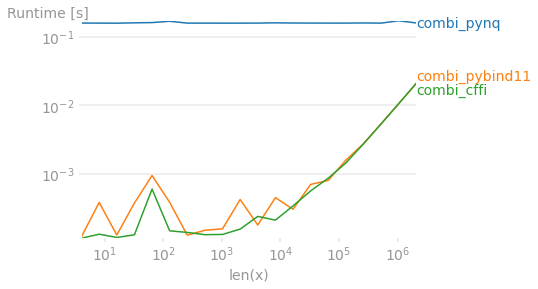

In [25]:
import time
from perfplot._main import PerfplotData

def _setup(n):
    A = allocate(shape=(n,), dtype="f4")
    B = allocate(shape=(n,), dtype="f4")
    C = allocate(shape=(n,), dtype="f4")

    A[:] = np.random.rand(n)
    B[:] = np.zeros(n)
    
    return A, B

kernels = [
    np_arcsinh_f4_combi_pynq,
    np_arcsinh_f4_combi_pybind11,
    np_arcsinh_f4_combi_cffi,
]

iters = 10
n_range = [2 ** k for k in range(2, 22)] 
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)

labels = ["combi_pynq", "combi_pybind11", "combi_cffi"]
xlabel = "len(x)"

for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):        
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        
        print(f"kernel = {j}, n = {n}, t = {timings_s[j,i]}")
        
    for x in data:
        x.freebuffer()
        
r = PerfplotData(
    n_range,
    timings_s,
    None,
    labels,
    xlabel
)

print(r)

r.show()

# Timing analysis overview

┏━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┓
┃ n     ┃ numpy ┃ pynq  ┃ pybi… ┃ cffi   ┃ pynq… ┃ pybin… ┃ cffi… ┃ combi… ┃ comb… ┃ combi… ┃
┡━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━┩
│ 4     │ 5.05… │ 0.11… │ 0.00… │ 0.000… │ 0.24… │ 0.000… │ 0.00… │ 0.160… │ 0.00… │ 0.000… │
│ 8     │ 4.78… │ 0.11… │ 0.00… │ 0.000… │ 0.24… │ 0.000… │ 0.00… │ 0.159… │ 0.00… │ 0.000… │
│ 16    │ 5.28… │ 0.11… │ 0.00… │ 0.000… │ 0.24… │ 0.000… │ 0.00… │ 0.159… │ 0.00… │ 0.000… │
│ 32    │ 6.14… │ 0.11… │ 0.00… │ 0.000… │ 0.24… │ 0.000… │ 0.00… │ 0.161… │ 0.00… │ 0.000… │
│ 64    │ 7.70… │ 0.11… │ 0.00… │ 0.000… │ 0.24… │ 0.000… │ 0.00… │ 0.162… │ 0.00… │ 0.000… │
│ 128   │ 0.00… │ 0.11… │ 0.00… │ 0.000… │ 0.24… │ 0.000… │ 0.00… │ 0.170… │ 0.00… │ 0.000… │
│ 256   │ 0.00… │ 0.12… │ 0.00… │ 0.000… │ 0.24… │ 0.000… │ 0.00… │ 0.159… │ 0.00… │ 0.000… │
│ 512   │ 0.00… │ 0.12… │ 0.00… │ 0.000… │ 0.25… │ 0.000… │ 0.00… │ 0.159… │ 0.00… │ 0.000… │
│ 1024  │ 0.00… │ 0.11… │ 0.00… │ 0.000… │ 0.24… │ 0.000… │ 0.00… │ 0.159… │ 0.00… │ 0.000… │
│ 2048  │ 0.00… │ 0.11… │ 0.00… │ 0.000… │ 0.24… │ 0.000… │ 0.00… │ 0.159… │ 0.00… │ 0.000… │
│ 4096  │ 0.00… │ 0.11… │ 0.00… │ 0.000… │ 0.24… │ 0.000… │ 0.00… │ 0.159… │ 0.00… │ 0.000… │
│ 8192  │ 0.00… │ 0.11… │ 0.00… │ 0.000… │ 0.24… │ 0.000… │ 0.00… │ 0.161… │ 0.00… │ 0.000… │
│ 16384 │ 0.00… │ 0.11… │ 0.00… │ 0.000… │ 0.24… │ 0.000… │ 0.00… │ 0.160… │ 0.00… │ 0.000… │
│ 32768 │ 0.01… │ 0.11… │ 0.00… │ 0.000… │ 0.24… │ 0.000… │ 0.00… │ 0.160… │ 0.00… │ 0.000… │
│ 65536 │ 0.03… │ 0.11… │ 0.00… │ 0.000… │ 0.24… │ 0.001… │ 0.00… │ 0.159… │ 0.00… │ 0.000… │
│ 1310… │ 0.07… │ 0.11… │ 0.00… │ 0.001… │ 0.24… │ 0.001… │ 0.00… │ 0.159… │ 0.00… │ 0.001… │
│ 2621… │ 0.15… │ 0.11… │ 0.00… │ 0.002… │ 0.25… │ 0.002… │ 0.00… │ 0.160… │ 0.00… │ 0.002… │
│ 5242… │ 0.30… │ 0.11… │ 0.00… │ 0.005… │ 0.24… │ 0.005… │ 0.00… │ 0.159… │ 0.00… │ 0.005… │
│ 1048… │ 0.61… │ 0.11… │ 0.01… │ 0.010… │ 0.24… │ 0.010… │ 0.01… │ 0.173… │ 0.01… │ 0.010… │
│ 2097… │ 1.23… │ 0.11… │ 0.02… │ 0.021… │ 0.24… │ 0.021… │ 0.02… │ 0.160… │ 0.02… │ 0.021… │
└───────┴───────┴───────┴───────┴────────┴───────┴────────┴───────┴────────┴───────┴────────┘

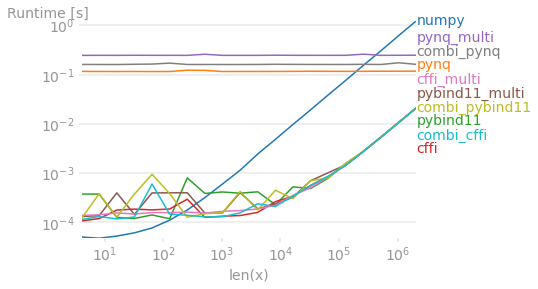

In [26]:
p.timings_s = np.concatenate((p.timings_s, q.timings_s, r.timings_s))
p.labels = p.labels + q.labels + r.labels

print(p)
p.show()